In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

gensch_palette = ['#0C4383', # ee
                '#22A0B6',  # free
                '#46E0A6', # equal distr
                '#7B1346', # error
                '#CB0C59'] # ddg 

plt.rcParams['font.size'] = 8.5
number_points = 100

def calc_metrics(data_orig, data_pred, only_test = False):

    # only from test set
    maes = []
    rmses = []
    r2s = []
    for col in data_pred.columns:
        if not 'Unnamed' in col and not 'T' in col:
            if only_test:
                train_idx, test_idx = train_test_split(range(len(data_pred)), test_size = 0.2, random_state = int(col))
                data_pred_test = data_pred[col].iloc[test_idx]
                data_orig_test = data_orig.iloc[test_idx]
            else:
                data_pred_test = data_pred[col]
                data_orig_test = data_orig
            mae = mean_absolute_error(data_orig_test, data_pred_test)
            rmse = np.sqrt(mean_squared_error(data_orig_test, data_pred_test))
            r2 = r2_score(data_orig_test, data_pred_test)
            maes.append(mae)
            rmses.append(rmse)
            r2s.append(r2)
    mae = np.mean(maes)
    rmse = np.mean(rmses)
    r2 = np.mean(r2s)
    return mae, rmse, r2

def load_both_datasets(dataset, tc, with_T):

    # original data
    df_orig = pd.read_csv(f'../code/datasets_230520/{dataset}.csv')

    # predicted data
    if with_T:
        with_T = 'withT'
    else:
        with_T = 'withoutT'

    df_pred = pd.read_csv(f'../code/nfold_det/{dataset}-GNN_{tc}_{with_T}.csv', delimiter=',')
    
    return df_orig, df_pred

def calc_ddg(ee, T, cap):
    '''
    ee in %
    T in Kelvin
    er = (1 + ee)/(1 - ee)
    er = exp(-ddg/RT)
    ln(er) = -ddg/RT
    ddg = -ln(er)RT
    '''
    # cap ee
    if ee > cap:
        ee = cap
    elif ee < -cap:
        ee = -cap
    T = float(T)
    R_const = 8.31446261815324/1000 # kJ / (mol K)
    er = (1 + ee/100) / (1 - ee/100)
    ddg = np.log(er) * R_const * T # kJ / mol
    ddg *= 1/4.1839954  # kcal / mol
    
    return ddg

def calc_switch(dataframe, T_frame, tc, cap):
    df_switched = pd.DataFrame()
    tc_sw = 'something_wrong_in_switching'
    df_list = []
    dataframe['T'] = T_frame['T']

    x = cap
    x_neg = -cap
    num_gt_x = (dataframe > x).sum().sum()
    num_gt_x_neg = (dataframe < x_neg).sum().sum()
    num_tot = num_gt_x + num_gt_x_neg
    total_predictions = dataframe.size
    cap_rate = num_tot
    for col in dataframe.columns:
        if col != 'T':
            if tc == 'ee':
                df_col = dataframe.apply(lambda row: calc_ddg(row[col], row['T'], cap), axis=1)
                tc_sw = 'ddg'
            df_list.append(df_col)
    df_switched = pd.concat(df_list, axis=1)
    dataframe = dataframe.drop(columns=['T'])
    df_switched.columns = dataframe.columns
    
    return df_switched, tc_sw, cap_rate

caps = np.linspace(99, 99.99, 40)
caps2 = np.linspace(99.99, 99.9999, 40)
caps3 = np.linspace(99.9999, 99.999999, 10)
caps4 = np.linspace(99.999999, 99.99999999, 10)

# combine caps and caps2

combined = np.concatenate([caps, caps2, caps3, caps4])
print(combined)
df_orig, df_pred = load_both_datasets('List_ACIE_THF', 'ee', True)

fig, ax1 = plt.subplots(figsize=(12, 12), dpi=300)
# Create a second y-axis
ax2 = ax1.twinx()
for cap in combined:
    if cap != 100:
        df_pred_switched, tc_sw, cap_rate = calc_switch(df_pred, df_orig, 'ee', cap)
        mae, rmse, r2  = calc_metrics(df_orig[tc_sw], df_pred_switched)
        ax1.scatter(cap, mae, c=gensch_palette[4], s=10)
        ax2.scatter(cap, cap_rate, c=gensch_palette[0], s=10)
plt.xlabel(r'Cap / \%')
ax1.set_ylabel('MAE / kcal mol$^{-1}$')
ax2.set_ylabel('Number of Capped Predictions / %$')
ax2.tick_params(axis='y', colors=gensch_palette[0])
ax2.spines['right'].set_color(gensch_palette[0])
plt.savefig('Fig6.png', dpi=300)
plt.close()



[99.         99.02538462 99.05076923 99.07615385 99.10153846 99.12692308
 99.15230769 99.17769231 99.20307692 99.22846154 99.25384615 99.27923077
 99.30461538 99.33       99.35538462 99.38076923 99.40615385 99.43153846
 99.45692308 99.48230769 99.50769231 99.53307692 99.55846154 99.58384615
 99.60923077 99.63461538 99.66       99.68538462 99.71076923 99.73615385
 99.76153846 99.78692308 99.81230769 99.83769231 99.86307692 99.88846154
 99.91384615 99.93923077 99.96461538 99.99       99.99       99.99025385
 99.99050769 99.99076154 99.99101538 99.99126923 99.99152308 99.99177692
 99.99203077 99.99228462 99.99253846 99.99279231 99.99304615 99.9933
 99.99355385 99.99380769 99.99406154 99.99431538 99.99456923 99.99482308
 99.99507692 99.99533077 99.99558462 99.99583846 99.99609231 99.99634615
 99.9966     99.99685385 99.99710769 99.99736154 99.99761538 99.99786923
 99.99812308 99.99837692 99.99863077 99.99888462 99.99913846 99.99939231
 99.99964615 99.9999     99.9999     99.999911   99.999

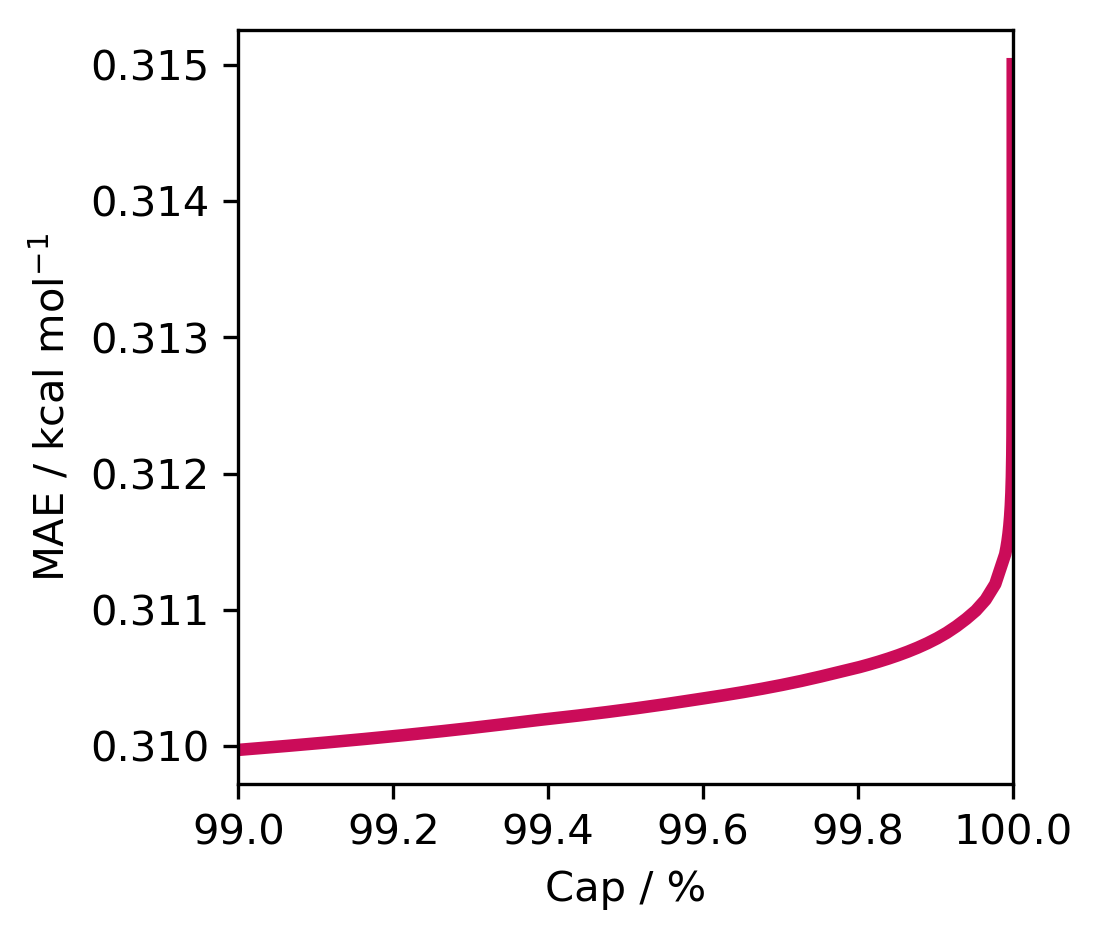

In [2]:
# combine functions to only take x
fig, ax1 = plt.subplots(figsize=(3.33, 3.33), dpi=300)
#ax2 = ax1.twinx()

df_orig, df_pred = load_both_datasets('List_ACIE_THF', 'ee', True)

caps = np.linspace(99, 99.99, 80)
caps2 = np.linspace(99.99, 99.9999, 80)
caps3 = np.linspace(99.9999, 99.999999, 80)
caps4 = np.linspace(99.999999, 99.99999999, 10)

def calc_switch(dataframe, T_frame, tc, cap):
    df_switched = pd.DataFrame()
    tc_sw = 'something_wrong_in_switching'
    df_list = []
    dataframe['T'] = T_frame['T']

    x = cap
    x_neg = -cap
    num_gt_x = (dataframe > x).sum().sum()
    num_gt_x_neg = (dataframe < x_neg).sum().sum()
    num_tot = num_gt_x + num_gt_x_neg
    total_predictions = dataframe.size
    capped = num_tot
    for col in dataframe.columns:
        if col != 'T':
            if tc == 'ee':
                df_col = dataframe.apply(lambda row: calc_ddg(row[col], row['T'], cap), axis=1)
                tc_sw = 'ddg'
            df_list.append(df_col)
    df_switched = pd.concat(df_list, axis=1)
    dataframe = dataframe.drop(columns=['T'])
    df_switched.columns = dataframe.columns
    
    return df_switched, tc_sw, capped

# combine caps and caps2

combined = np.concatenate([caps, caps2, caps3, caps4])

def f(x):
    df_pred_switched, tc_sw, cap_rate = calc_switch(df_pred, df_orig, 'ee', x)
    mae, rmse, r2  = calc_metrics(df_orig[tc_sw], df_pred_switched)
    return mae

def ge(x):
    df_pred_switched, tc_sw, cap_rate = calc_switch(df_pred, df_orig, 'ee', x)
    mae, rmse, r2  = calc_metrics(df_orig[tc_sw], df_pred_switched)
    return cap_rate

y = [f(x) for x in combined]

ax1.set_ylabel('MAE / kcal mol$^{-1}$')
ax1.plot(combined, y, color=gensch_palette[4], linewidth=3)
ax1.set_xlim(99, 100)
ax1.set_xlabel(r'Cap / %')

#ax2.set_ylabel('Number Capped Predictions')
#ax2.plot(combined, g, color=gensch_palette[0], linewidth=3)
#ax2.tick_params(axis='y', colors=gensch_palette[0])
#ax2.spines['right'].set_color(gensch_palette[0])

plt.savefig('Fig6.png', dpi=300)

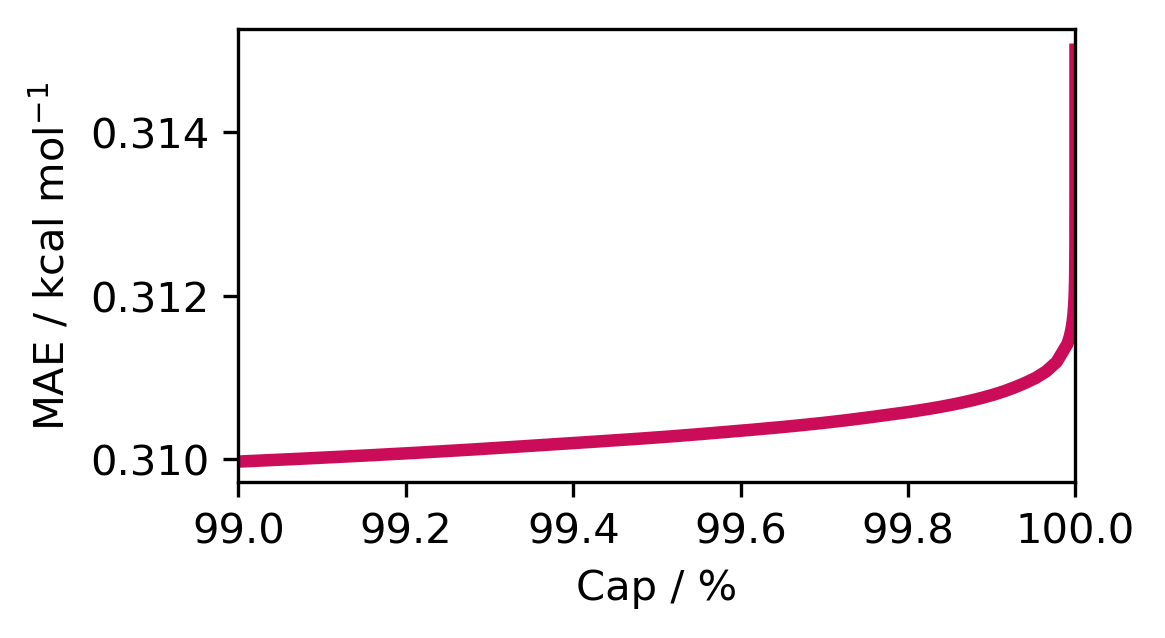

In [3]:
fig, ax1 = plt.subplots(figsize=(3.6, 2), dpi=300) # figsize in inches (width, height)
ax1.set_ylabel('MAE / kcal mol$^{-1}$')
ax1.plot(combined, y, color=gensch_palette[4], linewidth=3)
ax1.set_xlim(99, 100)
ax1.set_xlabel(r'Cap / %')

#ax2.set_ylabel('Number Capped Predictions')
#ax2.plot(combined, g, color=gensch_palette[0], linewidth=3)
#ax2.tick_params(axis='y', colors=gensch_palette[0])
#ax2.spines['right'].set_color(gensch_palette[0])

plt.savefig('Fig6.png', dpi=300)